#*Application of machine learning methods to identify and categorize radio pulsar signal candidates*


##Import Libraries and Dataset

In [12]:
from google.colab import files
uploaded = files.upload()   # A file chooser will appear – select HTRU_2.csv


Saving HTRU_2.csv to HTRU_2 (1).csv


In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc


##Loading Dataset


   Mean_of_IP   SD_of_IP  EK_of_IP  Skew_of_IP  Mean_of_DM_SNR  SD_of_DM_SNR  \
0  140.562500  55.683782 -0.234571   -0.699648        3.199833     19.110426   
1  102.507812  58.882430  0.465318   -0.515088        1.677258     14.860146   
2  103.015625  39.341649  0.323328    1.051164        3.121237     21.744669   
3  136.750000  57.178449 -0.068415   -0.636238        3.642977     20.959280   
4   88.726562  40.672225  0.600866    1.123492        1.178930     11.468720   

   EK_of_DM_SNR  Skew_of_DM_SNR  target_class  
0      7.975532       74.242225             0  
1     10.576487      127.393580             0  
2      7.735822       63.171909             0  
3      6.896499       53.593661             0  
4     14.269573      252.567306             0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Mean_of_IP      17898 non-nu

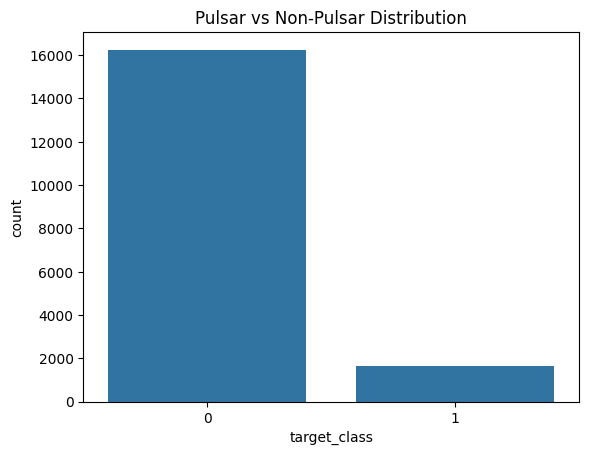

In [15]:
data = pd.read_csv("HTRU_2.csv", header=None)
data.columns = [
    "Mean_of_IP", "SD_of_IP", "EK_of_IP", "Skew_of_IP",
    "Mean_of_DM_SNR", "SD_of_DM_SNR", "EK_of_DM_SNR", "Skew_of_DM_SNR",
    "target_class"
]

# Quick overview
print(data.head())
print(data.info())
print(data['target_class'].value_counts())

# Visualize target distribution
sns.countplot(x='target_class', data=data)
plt.title("Pulsar vs Non-Pulsar Distribution")
plt.show()

##Preprocessing

In [16]:
X = data.drop(columns='target_class')
y = data['target_class']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

##Train Baseline Models

In [17]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(kernel='rbf', random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"=== {name} ===")
    print("Accuracy:", model.score(X_test, y_test))
    print(classification_report(y_test, y_pred))

=== Logistic Regression ===
Accuracy: 0.979608938547486
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3252
           1       0.94      0.83      0.88       328

    accuracy                           0.98      3580
   macro avg       0.96      0.91      0.94      3580
weighted avg       0.98      0.98      0.98      3580

=== Random Forest ===
Accuracy: 0.982122905027933
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3252
           1       0.93      0.87      0.90       328

    accuracy                           0.98      3580
   macro avg       0.96      0.93      0.94      3580
weighted avg       0.98      0.98      0.98      3580

=== SVM ===
Accuracy: 0.9807262569832402
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3252
           1       0.95      0.84      0.89       328

    accuracy                       

##Hyperparameter Tuning

In [18]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

# Evaluate tuned model
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
print("=== Random Forest (Tuned) ===")
print("Accuracy:", best_rf.score(X_test, y_test))
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
=== Random Forest (Tuned) ===
Accuracy: 0.9807262569832402
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3252
           1       0.92      0.86      0.89       328

    accuracy                           0.98      3580
   macro avg       0.95      0.93      0.94      3580
weighted avg       0.98      0.98      0.98      3580



##Confusion Matrix

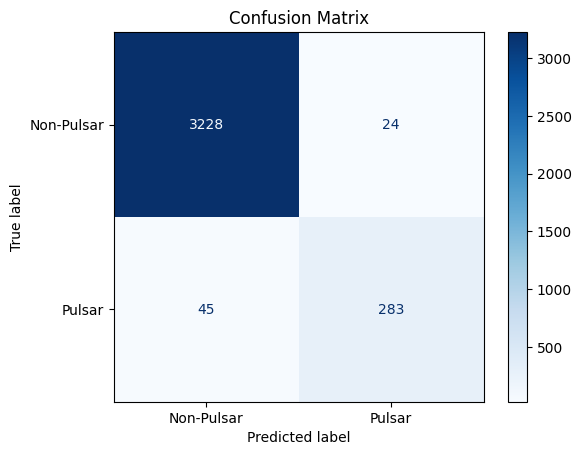

In [19]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Pulsar', 'Pulsar'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

##Feature Importance

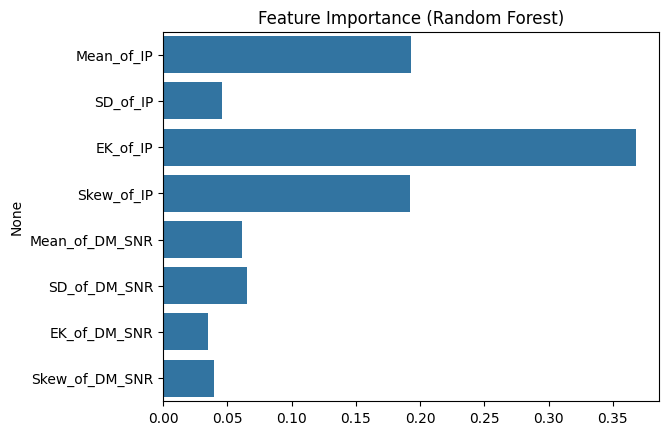

In [20]:
importances = best_rf.feature_importances_
features = X.columns
sns.barplot(x=importances, y=features)
plt.title("Feature Importance (Random Forest)")
plt.show()

##ROC Curve

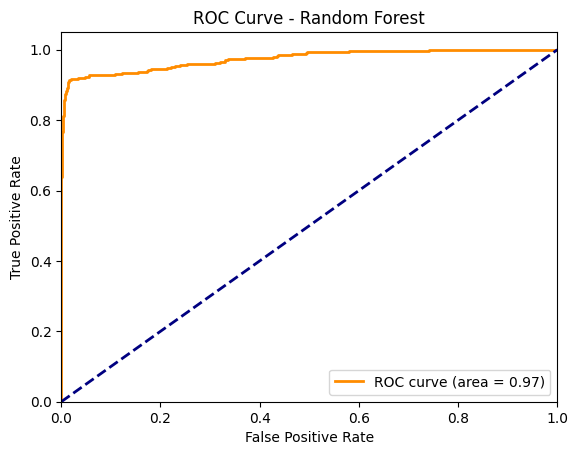

In [21]:
y_prob = best_rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()

In [22]:
import joblib
joblib.dump(best_rf, "best_rf_model.pkl")

['best_rf_model.pkl']